# Import Libraries

In [1]:
# Import your basic libraries
import pandas as pd
import numpy as np
import math, time
import matplotlib.pyplot as plt

# Import libraries for KNN modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Import libraries for Random Forest modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Import libraries for ANN
from sklearn.neural_network import MLPClassifier

In [2]:
# Import the csv file and view the head of the data
csgoData = pd.read_csv('csgo_round_snapshots.csv')

In [3]:
# Check for NA values
isNA = csgoData.isnull().sum()
naCounter = 0

for i in isNA:
    if i > 0:
        print('NA: ',i)
        naCounter += i

print('Missing values: %s' % naCounter)

Missing values: 0


In [4]:
# Grab a list of the column names
colNames = []
for col in csgoData.columns:
    colNames.append(col)

In [5]:
def buildRounds(csgoData):
    # Set up a new list to hold all of the round summaries
    rounds = []

    # Set up loop params to summarize rounds
    counter = 0
    lim = len(csgoData) # This will be set to len(csgoData) once it is ready
    startPoint = 0
    
    # Iterate through the data set to slice the rounds
    print('Grouping snapshots into rounds...')
    while counter < lim + 1:

        roundOver = 'FALSE'
        prev = 180

        # Loop for only the snapshots within the round
        while roundOver == 'FALSE':
            if counter == lim:
                roundSum = []
                roundSlice = csgoData.loc[startPoint:counter-1]

                # print('Round Over - %s won the round' % csgoData['round_winner'][counter]) # -> Used to determine if the round has been completed (new round started) # -> Debug line
                
                # Some debugging lines
                '''
                print(roundSlice) -> This is to validate that the rounds are being sliced properly
                print(roundSlice.iloc[0]) -> Used to test if I can pull the first row of the slice
                print(roundSlice.iloc[len(roundSlice)-1]) -> Used to test if I can pull the last row of the slice
                '''

                # Set some of the values according to the end of the round
                roundSum.append(roundSlice.iloc[len(roundSlice)-1]['ct_score'])
                roundSum.append(roundSlice.iloc[len(roundSlice)-1]['t_score'])
                roundSum.append(roundSlice.iloc[len(roundSlice)-1]['map'])
                roundSum.append(roundSlice.iloc[len(roundSlice)-1]['bomb_planted'])
                
                # Set the remaining values according to the beginning of the round
                for i in roundSlice.iloc[1][5:97]:
                    roundSum.append(i)
                
                # Test to see if there is a short round that indicates inaccurate data capture
                if len(roundSlice) <= 2 and roundSum[0] == rounds[len(rounds)-1][0] and roundSum[1] == rounds[len(rounds)-1][1]:
                    print('Round %s Triggered: Short round - Ignoring it...\n' % counter)
                else:
                    rounds.append(roundSum)

                del roundSum

                return rounds

            elif counter < lim:
                if csgoData['time_left'][counter] > prev and csgoData['time_left'][counter] > 165:
                    
                    roundSum = []
                    roundSlice = csgoData.loc[startPoint:counter-1]

                    # print('Round Over - %s won the round' % csgoData['round_winner'][counter]) # -> Used to determine if the round has been completed (new round started) # -> Debug line
                    
                    # Some debugging lines
                    '''
                    print(roundSlice) -> This is to validate that the rounds are being sliced properly
                    print(roundSlice.iloc[0]) -> Used to test if I can pull the first row of the slice
                    print(roundSlice.iloc[len(roundSlice)-1]) -> Used to test if I can pull the last row of the slice
                    '''

                    # Set some of the values according to the end of the round
                    roundSum.append(roundSlice.iloc[len(roundSlice)-1]['ct_score'])
                    roundSum.append(roundSlice.iloc[len(roundSlice)-1]['t_score'])
                    roundSum.append(roundSlice.iloc[len(roundSlice)-1]['map'])
                    roundSum.append(roundSlice.iloc[len(roundSlice)-1]['bomb_planted'])
                    
                    # Set the remaining values according to the beginning of the round
                    for i in roundSlice.iloc[1][5:97]:
                        roundSum.append(i)
                    
                    # Test to see if there is a short round that indicates inaccurate data capture
                    if len(roundSlice) <= 2 and roundSum[0] == rounds[len(rounds)-1][0] and roundSum[1] == rounds[len(rounds)-1][1]:
                        print('Round %s Triggered: Short round - Ignoring it...\n' % counter)
                    else:
                        rounds.append(roundSum)

                    del roundSum

                    roundOver = 'TRUE'
                    startPoint = counter  
                
                # Test for repeated rows in the data
                elif csgoData['time_left'][counter] == prev:
                    # print('Repeat row - ignoring...') # -> Debug line
                    prev = csgoData['time_left'][counter]

                # Round not over yet, so set the new reference time value for the next iteration
                else:
                    # print('Round not over. Time remaining: %s' % csgoData['time_left'][counter]) # -> Used to test if the round timer was being referenced properly
                    prev = csgoData['time_left'][counter]
                
                counter += 1

In [6]:
# Create the new data frame
rounds = buildRounds(csgoData)
roundDF = pd.DataFrame(rounds, columns = colNames[1:97])

# Convert the data to necessary values (numeric) and split it into target and attributes
toNum = {'CT': 0, 'T': 1}
roundDF.replace({'CT': toNum, 'T': toNum})

# Show the first few rows
print(roundDF.head())

Grouping snapshots into rounds...
   ct_score  t_score       map  bomb_planted  ct_health  t_health  ct_armor  \
0       0.0      0.0  de_dust2         False      500.0     500.0     400.0   
1       1.0      0.0  de_dust2         False      500.0     500.0     500.0   
2       2.0      0.0  de_dust2         False      500.0     500.0     496.0   
3       2.0      1.0  de_dust2          True      500.0     500.0     500.0   
4       3.0      1.0  de_dust2          True      500.0     500.0     499.0   

   t_armor  ct_money  t_money  ...  t_grenade_flashbang  \
0    300.0     600.0    650.0  ...                  0.0   
1      0.0    1750.0  10550.0  ...                  0.0   
2    500.0    2200.0   1000.0  ...                  5.0   
3    474.0     850.0   3150.0  ...                  5.0   
4    493.0   12100.0   2200.0  ...                  4.0   

   ct_grenade_smokegrenade  t_grenade_smokegrenade  \
0                      0.0                     2.0   
1                      3.0  

# Create test and training sets

In [7]:
# Convert the strings in 'map' attribute to numerical values
tmpMaps = []
for i in roundDF['map']:
    if i not in tmpMaps:
        tmpMaps.append(i)

mapVals = list(range(1,len(tmpMaps)+1)) # Formerly a list of values 1-8

tmpBomb = [False, True]
bombVals = [0, 1]

roundDF.replace(to_replace = tmpMaps, value = mapVals, inplace=True)
roundDF.replace(to_replace = tmpBomb, value = bombVals, inplace=True)    

# Split the rounds into two different dataframes: attributes and target
x = roundDF[colNames[3:-1]] # Attributes
y = roundDF['round_winner'] # Target

# Split the data into training and test sets
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

# KNN Model

In [8]:
# Apply the KNN methodology using the training sets for attributes and taget starting with k as the square root of the length of the training set
print('Finding the best k value between 1 and square root of the length of the data')

# Find accuracy rate for each k and store it
accuracyRates = []
lim = int(math.sqrt(len(xTrain)))
kRange = list(range(1, lim))

for i in kRange:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(xTrain, yTrain)
    accuracyRates.append(knn.score(xTest, yTest))

# Find the highest 
highest = [1, 0]
for i in kRange:
    pair = (i, accuracyRates[i-1])
    if accuracyRates[i-1] > highest[1]:
        highest[0] = i
        highest[1] = accuracyRates[i-1]

# Print the best k value
bestK = (highest[0], highest[1])
print('Best K: %s\tAccuracy Rate: %s\n' % bestK)

Finding the best k value between 1 and square root of the length of the data
Best K: 121	Accuracy Rate: 0.7295563869588455



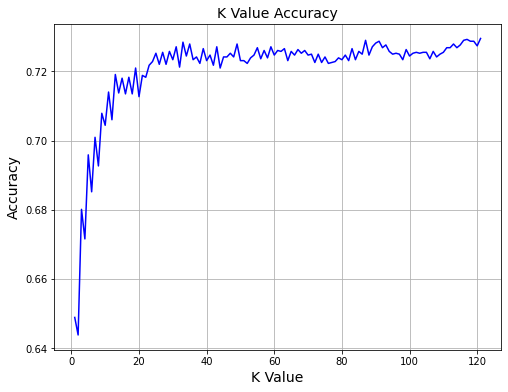

In [9]:
# Show a line graph with k values
plt.figure(figsize=(8, 6))
plt.plot(kRange, accuracyRates, color='blue')

plt.title('K Value Accuracy', fontsize=14)
plt.xlabel('K Value', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True)

plt.show()

In [10]:
# Re-fit the data to best k
knn = KNeighborsClassifier(n_neighbors=highest[0])
knn.fit(xTrain, yTrain)

# Print the accuracy rate for the best k
bestKTrain = knn.score(xTrain, yTrain) * 100
bestKTest = knn.score(xTest, yTest) * 100
pPair = (bestKTrain, bestKTest)

print('KNN Training Accuracy: %s\nKNN Test Accuracy: %s' % pPair)

KNN Training Accuracy: 73.67858336117608
KNN Test Accuracy: 72.95563869588455


# Random Forests

In [36]:
# Build the forest using pre-determined tree counts
print('Calculating Random Forests...')
rfResults = []
nTrees = [1, 5, 10, 20, 50, 100, 500, 1000, 3000, 5000]
for i in nTrees:
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(xTrain, yTrain)

    # Create a prediction using the model
    yPrediction = rf.predict(xTest)

    # Print accuracy rate of preliminary forest
    rfAccuracy = metrics.accuracy_score(yTest, yPrediction) * 100
    rfAccuracy = '{0:.3f}'.format(rfAccuracy)
    tmpResult = [i, rfAccuracy]
    rfResults.append(tmpResult)

print('Done')

Calculating Random Forests...
Done


In [41]:
# Convert results to dataframe and display them
rfResults = pd.DataFrame(rfResults, columns = ['Trees', 'Accuracy'])
print(rfResults)

   Trees Accuracy
0      1   65.740
1      5   71.807
2     10   73.650
3     20   74.425
4     50   76.002
5    100   76.243
6    500   76.590
7   1000   76.430
8   3000   76.590
9   5000   76.430


In [43]:
# Find the best tree count based on accuracy
lim = list(range(0, len(rfResults)))
bestTrees = [1, 0.0]

for i in lim:
    tmpAcc = rfResults.iloc[i]['Accuracy']
    tmpAcc = float(tmpAcc)
    if tmpAcc >= float(bestTrees[1]):
        bestTrees[0] = rfResults.iloc[i]['Trees']
        bestTrees[1] = rfResults.iloc[i]['Accuracy']
        
# Re-fit the data using best tree count
rf = RandomForestClassifier(n_estimators=bestTrees[0])
rf.fit(xTrain, yTrain)

# Print results
print('Results of Random Forests model\n')
print('Best Trees: %s' % bestTrees[0])

bestRFTrain = rf.score(xTrain, yTrain) * 100
bestRFTest = rf.score(xTest, yTest) * 100
pPair = (bestRFTrain, bestRFTest)

print('RF Training Accuracy: %s\nRF Test Accuracy: %s' % pPair)

Results of Random Forests model

Best Trees: 3000
RF Training Accuracy: 99.52555963915803
RF Test Accuracy: 76.50988776055586
